<a href="https://colab.research.google.com/github/ShilpaBombale/Fine-Tuning-Projects/blob/main/distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning a Language Model for Sentiment Analysis on Movie Review Dataset

Base Model: distilbert-base-uncased

Dataset: imdb-truncated

Training Technique: LoRA

In [ ]:
pip install datasets transformers peft evaluate


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
pip install datasets

In [ ]:
pip install transformers


In [ ]:
pip install peft

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
)

### dataset

In [ ]:
# load dataset
dataset = load_dataset('shawhin/imdb-truncated')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [ ]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.5

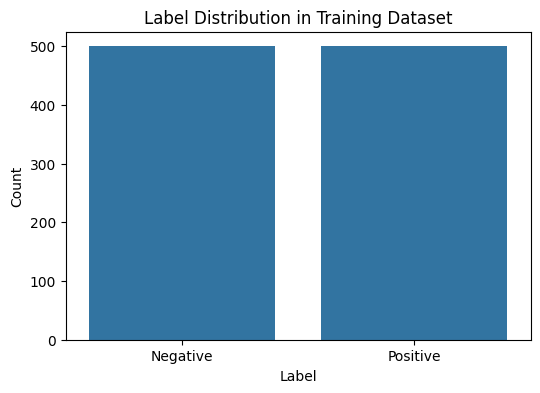

In [ ]:


# Convert the dataset to a pandas DataFrame
train_df = pd.DataFrame(dataset['train'])

# Plot the distribution of labels in the training dataset
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df['label'])
plt.title('Label Distribution in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

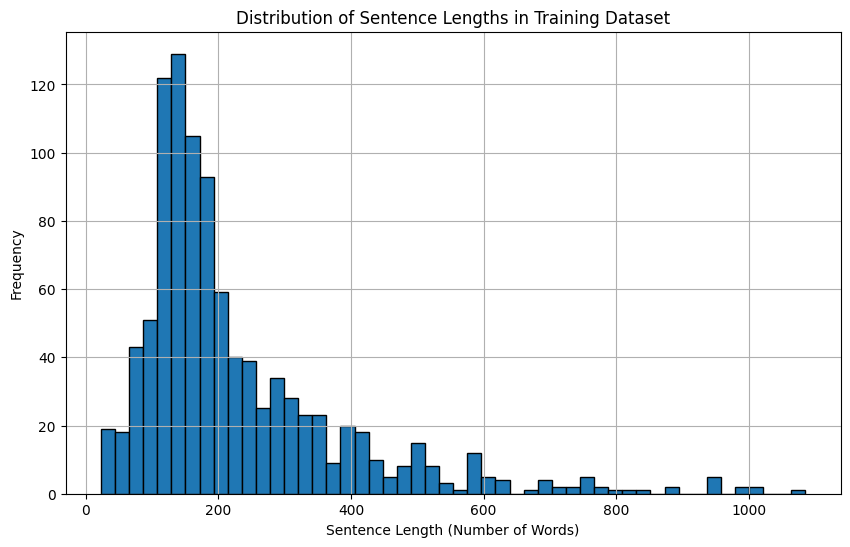

In [ ]:
# Calculate the length of each sentence in the training dataset
train_texts = dataset['train']['text']
sentence_lengths = [len(text.split()) for text in train_texts]

# Plot histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Sentence Lengths in Training Dataset')
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### model

In [ ]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### preprocess data

In [ ]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [ ]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [ ]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### evaluation

In [ ]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Accuracy
    accuracy = accuracy_score(labels, predictions)

    # Precision, Recall, F1 Score
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # True Positive Rate (TPR) and False Positive Rate (FPR)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true_positive_rate": tpr,
        "false_positive_rate": fpr
    }


### Apply untrained model to text

In [ ]:
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "Worst movie ever.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Positive
Not a fan, don't recommed. - Positive
Better than the first one. - Positive
Worst movie ever. - Positive
This one is a pass. - Positive


### Train model

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9307


In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 10

In [ ]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positive Rate,False Positive Rate
1,No log,0.325820,0.880000,0.883065,0.876000,0.879518,0.876000,0.116000
2,0.418600,0.600299,0.859000,0.932530,0.774000,0.845902,0.774000,0.056000
3,0.418600,0.579217,0.884000,0.915584,0.846000,0.879418,0.846000,0.078000
4,0.194800,0.595268,0.884000,0.896694,0.868000,0.882114,0.868000,0.100000
5,0.194800,0.766746,0.890000,0.916667,0.858000,0.886364,0.858000,0.078000
6,0.056000,0.930989,0.874000,0.897872,0.844000,0.870103,0.844000,0.096000
7,0.056000,0.995438,0.877000,0.890269,0.860000,0.874873,0.860000,0.106000
8,0.018300,0.955019,0.886000,0.876953,0.898000,0.887352,0.898000,0.126000
9,0.018300,0.988202,0.887000,0.889336,0.884000,0.886660,0.884000,0.110000
10,0.002100,0.998807,0.886000,0.884462,0.888000,0.886228,0.888000,0.116000


TrainOutput(global_step=2500, training_loss=0.13796373338699341, metrics={'train_runtime': 477.8445, 'train_samples_per_second': 20.927, 'train_steps_per_second': 5.232, 'total_flos': 1112883852759936.0, 'train_loss': 0.13796373338699341, 'epoch': 10.0})

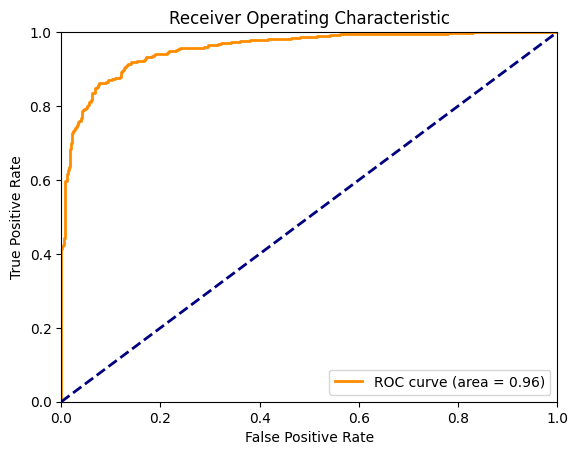

In [ ]:
# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Plot ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

eval_dataset = tokenized_dataset["validation"]
true_labels = np.array(eval_dataset["label"])

trainer.model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = []
    for batch in trainer.get_eval_dataloader():
        inputs = {k: v.to(trainer.args.device) for k, v in batch.items() if k != 'labels'}
        logits = trainer.model(**inputs).logits
        predictions.extend(torch.softmax(logits, dim=-1).cpu().numpy()[:, 1])  # Get probabilities for the positive class

fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Generate prediction

In [ ]:
model.to('cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu")
    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
It was good. - Positive
Not a fan, don't recommed. - Negative
Better than the first one. - Positive
Worst movie ever. - Negative
This one is a pass. - Negative


In [ ]:
# Save the trained model explicitly
model_save_path = training_args.output_dir
trainer.save_model(model_save_path)